# **Deep Learning Volume Segmentation (3D UNet)**

Authors: Anna Ekner (s193396@dtu.dk)

This notebook aims to demonstrate the feasibility of implementing a comprehensive deep learning segmentation pipeline solely leveraging the capabilities offered by the `qim3d` library. Specifically, it highlights the use of the synthetic data generation functionalities to create a volumetric dataset with associated labels, and walks through the process of creating and training a 3D UNet model using this synthetic dataset.

In [1]:
import qim3d
import glob
import os
import numpy as np

### **1. Generate synthetic dataset**

#### 1.1 Example of data sample (probably should be after creating the dataset??)

Synthetic dataset and associated labels.

In [11]:
# num_objects = 5
# vol, labels = qim3d.generate.noise_object_collection(
#     num_objects = num_objects,
#     collection_shape = (128, 128, 128),
#     min_object_noise = 0.03, 
#     max_object_noise = 0.08,
#     )

In [10]:
# Visualize synthetic collection
# qim3d.viz.volumetric(vol)

In [30]:
# Visualize slices
# qim3d.viz.slicer(vol)

There will be $N + 1$ unique labels, because one extra for background.
But we want only 2 labels: foreground and background.

In [3]:
# # Convert N + 1 labels into 2 labels (background and object)
# labels = (labels > 0).astype(int)

In [29]:
# Visualize labels
# qim3d.viz.slicer(labels)

#### 1.2 Create folder structure

In [2]:
# Base path for the training data
base_path = os.path.expanduser("~/dataset")

In [12]:
# Create directories
print("Creating directories:")

for folder_split in ["train", "test"]:
    for folder_type in ["images", "labels"]:
        
        path = os.path.join(base_path, folder_split, folder_type)
        os.makedirs(path, exist_ok=True)
        print(path)

# Here we have the option to remove any previous files
clean_files = True
if clean_files:
    for root, dirs, files in os.walk(base_path):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

Creating directories:
C:\Users\s193396/dataset\train\images
C:\Users\s193396/dataset\train\labels
C:\Users\s193396/dataset\test\images
C:\Users\s193396/dataset\test\labels


#### 1.3 Create dataset

We need to create a dataset of multiple volumes

In [13]:
# Specify the number of training and testing samples
num_train = 4
num_test = 1

In [14]:
# Specify the number of objects in each volume
num_objects = 5

# Generate training and testing samples
for idx in range(num_train + num_test):

    # Determine the folder split (train or test)
    if idx < num_train:
        folder_split = "train"

    else:
        folder_split = "test"

    # TODO: Figure out whether or not the seed makes it such that all volumes are identical?

    vol, label = qim3d.generate.noise_object_collection(
        num_objects=num_objects,
        collection_shape=(128, 128, 128),
        min_object_noise=0.03,
        max_object_noise=0.08,
    )

    # Convert N + 1 labels into 2 labels (background and object)
    label = (label > 0).astype(int)

    # Save volume
    qim3d.io.save(os.path.join(base_path, folder_split, "images", f"{idx + 1}.nii.gz"), vol, compression = True, replace=True)

    # Save label
    qim3d.io.save(os.path.join(base_path, folder_split, "labels", f"{idx + 1}.nii.gz"), label, compression = True, replace=True)

Objects placed:   0%|          | 0/5 [00:00<?, ?it/s]

Objects placed:   0%|          | 0/5 [00:00<?, ?it/s]

Objects placed:   0%|          | 0/5 [00:00<?, ?it/s]

Objects placed:   0%|          | 0/5 [00:00<?, ?it/s]

Objects placed:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# Check the image indices for training and testing data
for folder_split in ["train", "test"]:

    path = os.path.join(base_path, folder_split, "images")
    files = os.listdir(path)
    files = [int(os.path.basename(f)[0]) for f in files]

    if folder_split == "train":
        print(f"Image indices for training data.....: {files}")
    
    elif folder_split == "test":
        print(f"Image indices for testing data......: {files}")


Image indices for training data.....: [1, 2, 3, 4]
Image indices for testing data......: [5]


### **2. Build 3D UNet model**

#### 2.1 Instantiate UNet model

In [3]:
model = qim3d.ml.models.UNet(size = 'small', dropout = 0.25)

#### 2.2 Define augmentations

In [3]:
augmentation =  qim3d.ml.Augmentation(resize = 'crop', transform_train = 'light')

#### 2.3 Divide dataset into train and test splits

In [9]:
# # Debug stuff
# import qim3d
# import numpy as np

# vol, labels = qim3d.generate.noise_object_collection(
#     num_objects = 1,
#     collection_shape = (128, 128, 128),
#     min_object_noise = 0.03, 
#     max_object_noise = 0.04,
#     )

# augmentation =  qim3d.ml.Augmentation(resize = 'crop', transform_train = 'light')

# print(f"Before augmentation: {vol.shape} and {vol.dtype}")
# print(f"Augmentation: {augmentation}\n")

# compose_augmentation = augmentation.augment(*vol.shape, level = augmentation.transform_train)
# vol_expanded = np.expand_dims(vol, axis = 0)
# transformed_vol = compose_augmentation(vol_expanded)

# print(f"After channel expansion and augmentation: {transformed_vol.shape}")
# print(f"Dtype after augmentation: {transformed_vol.dtype}\n")

# # Remove the channel dimension
# vol_reduced = np.squeeze(transformed_vol)

# print(f"After reducing channel dimension: {vol_reduced.shape}")

# # qim3d.viz.volumetric(vol_reduced)

Objects placed:   0%|          | 0/1 [00:00<?, ?it/s]

Before augmentation: (128, 128, 128) and uint8
Augmentation: <qim3d.ml._augmentations.Augmentation object at 0x0000028B367D1870>

After channel expansion and augmentation: torch.Size([1, 128, 128, 128])
Dtype after augmentation: torch.uint8

After reducing channel dimension: (128, 128, 128)


Stuff

In [4]:
# datasets and dataloaders
train_set, val_set, test_set = qim3d.ml.prepare_datasets(path = base_path,
                                                         val_fraction = 0.5,
                                                         model = model,
                                                         augmentation = augmentation)


train_loader, val_loader, test_loader = qim3d.ml.prepare_dataloaders(train_set, 
                                                                     val_set,
                                                                     test_set,
                                                                     batch_size = 1,
                                                                     num_workers = 0)

NameError: name 'model' is not defined

### **3. Train model**

#### 3.1 Define training hyperparameters

In [5]:
# hyperparameters
hyperparameters = qim3d.ml.Hyperparameters(model, n_epochs=10, 
                                           learning_rate = 5e-3, loss_function='DiceCE',
                                           weight_decay=1e-3)

NameError: name 'model' is not defined

#### 3.2 Train model

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   0, train loss: 1.6856, val loss: 1.6405
Epoch   5, train loss: 1.4391, val loss: 0.5096


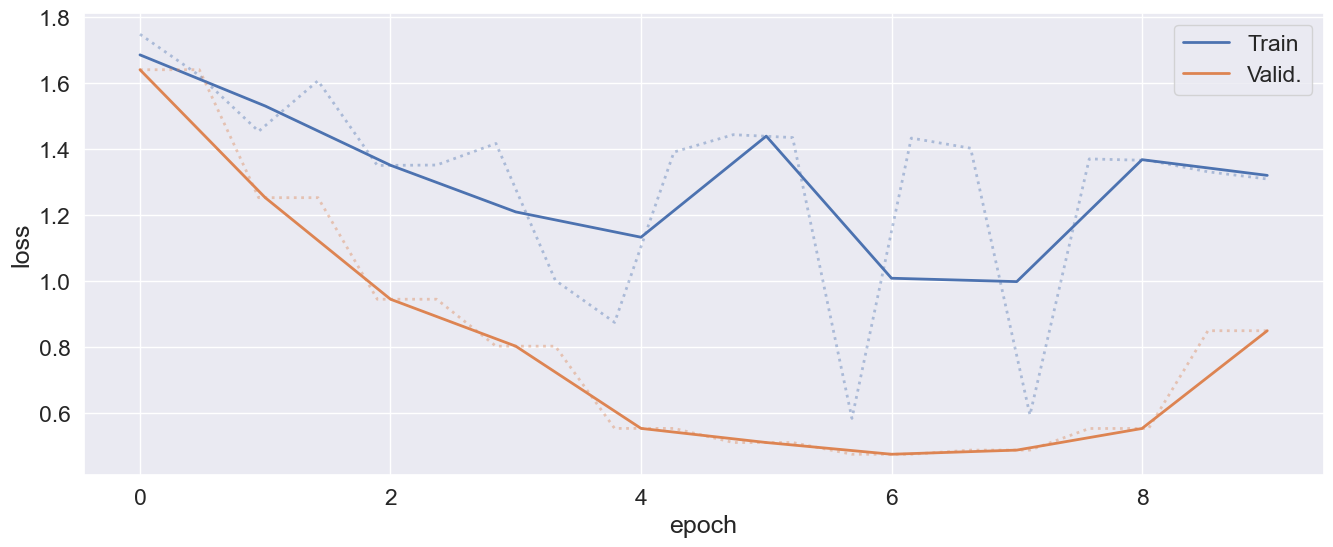

In [7]:
# training model
qim3d.ml.train_model(model, hyperparameters, train_loader, val_loader, plot=True)

## This is where the good stuff is at (below)

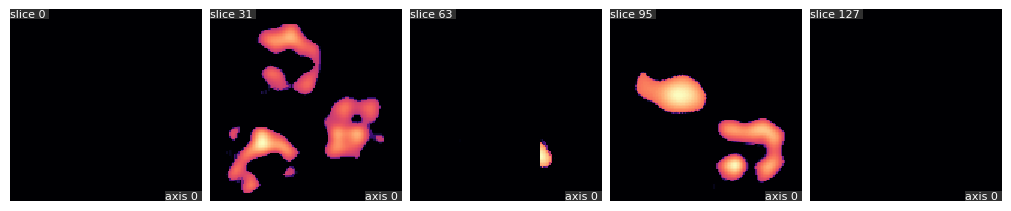

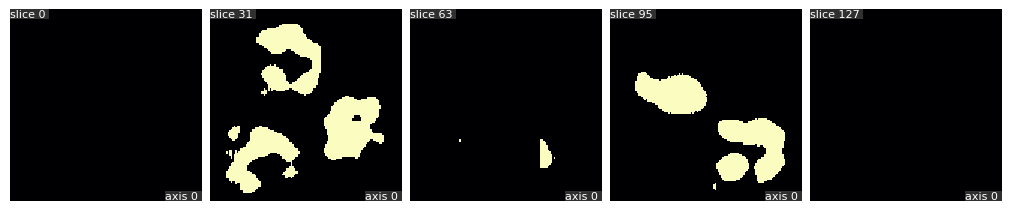

In [1]:
# 
import qim3d
import glob
import torch
import os
import numpy as np

base_path = os.path.expanduser("~/dataset")
model = qim3d.ml.models.UNet(size = 'small')
augmentation =  qim3d.ml.Augmentation(resize = 'crop', transform_train = 'light') # transform_train = 'None')

# datasets and dataloaders
train_set, val_set, test_set = qim3d.ml.prepare_datasets(path = base_path,
                                                         val_fraction = 0.5,
                                                         model = model,
                                                         augmentation = augmentation)


train_loader, val_loader, test_loader = qim3d.ml.prepare_dataloaders(train_set, 
                                                                     val_set,
                                                                     test_set,
                                                                     batch_size = 1,
                                                                     num_workers = 0)

# for data in train_loader:
#     inputs, targets = data
#     inputs = inputs.squeeze().numpy()
#     targets = targets.squeeze().numpy()

# qim3d.viz.slices_grid(inputs, num_slices=5, display_figure=True)
# qim3d.viz.slices_grid(targets, num_slices=5)

hyperparameters = qim3d.ml.Hyperparameters(model, n_epochs=10, 
                                           learning_rate = 5e-3, loss_function='DiceCE',
                                           weight_decay=1e-3)

# qim3d.ml.train_model(model, hyperparameters, train_loader, val_loader, plot=True)

model.load_state_dict(torch.load(f'{base_path}/this_works_with_resunits_with_aug.pth'))


### **4. Test model**

Number of volumes: 2
Volume shape: (128, 128, 128)
Target shape: (128, 128, 128)
Preds shape: (128, 128, 128)


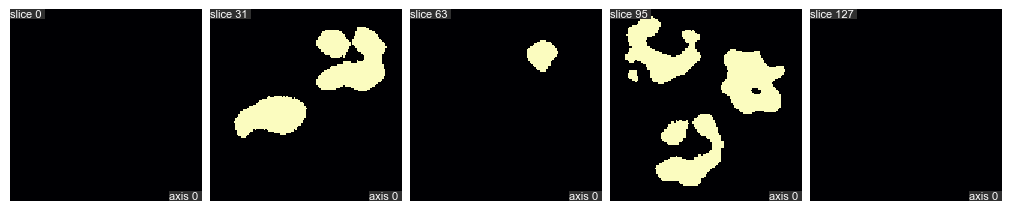

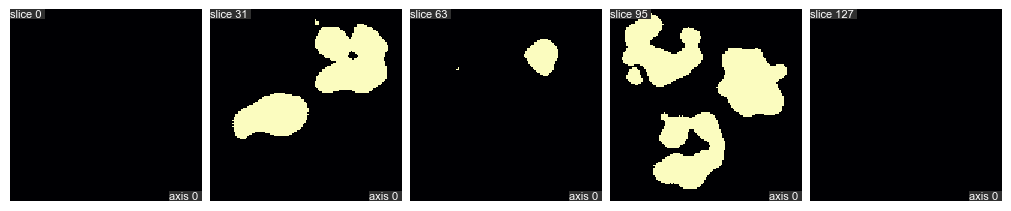

In [7]:
# Inference on train set
results = qim3d.ml.inference(train_set, model)
train_volume, train_target, train_preds = results[0]

print(f"Number of train volumes: {len(results)}")
print(f"Volume shape: {train_volume.shape}")
print(f"Target shape: {train_target.shape}")
print(f"Preds shape: {train_preds.shape}")

qim3d.viz.slices_grid(train_target, num_slices=5, display_figure=True)
qim3d.viz.slices_grid(train_preds, num_slices=5)

Number of test volumes: 1
Volume shape: (128, 128, 128)
Target shape: (128, 128, 128)
Preds shape: (128, 128, 128)


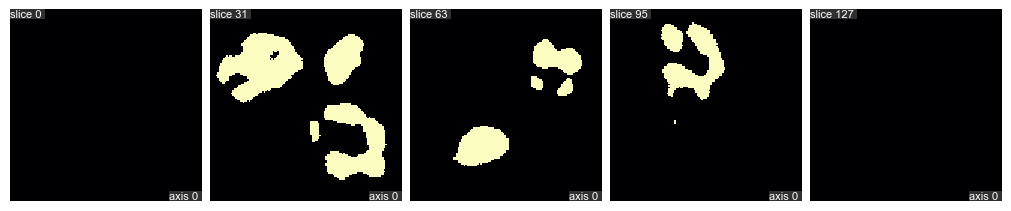

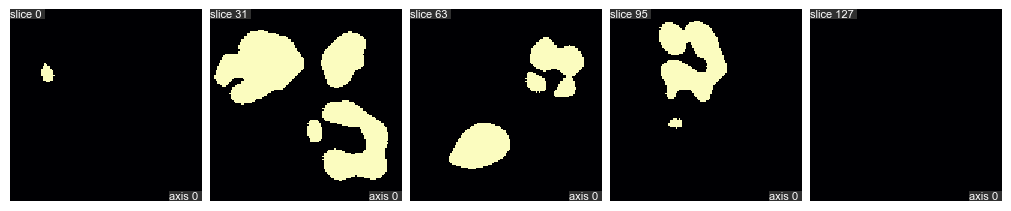

In [9]:
# Inference on test set
results = qim3d.ml.inference(test_set, model)
test_volume, test_target, test_preds = results[0]

print(f"Number of test volumes: {len(results)}")
print(f"Volume shape: {test_volume.shape}")
print(f"Target shape: {test_target.shape}")
print(f"Preds shape: {test_preds.shape}")

qim3d.viz.slices_grid(test_target, num_slices=5, display_figure=True)
qim3d.viz.slices_grid(test_preds, num_slices=5)

In [11]:
print(np.unique(target, return_counts=True))
print(np.unique(preds, return_counts=True))

(array([0., 1.], dtype=float32), array([1885162,  211990], dtype=int64))
(array([0., 1.], dtype=float32), array([1911254,  185898], dtype=int64))


In [ ]:
# Inference volume
vol, label = qim3d.generate.noise_object_collection(
    num_objects=5,
    collection_shape=(128, 128, 128),
    min_object_noise=0.03,
    max_object_noise=0.08,
)

# Convert N + 1 labels into 2 labels (background and object)
label = (label > 0).astype(int)

Objects placed:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
print(f"Volume shape: {vol.shape}")

Volume shape: (128, 128, 128)


In [10]:
inference_vol = qim3d.ml.volume_inference(vol, model)
qim3d.viz.slicer(inference_vol)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 128 but got size 256 for tensor number 1 in the list.

In [ ]:
vol_masked = qim3d.viz.vol_masked(vol, inference_vol, viz_delta=128)
qim3d.viz.slicer(vol_masked, color_map="PiYG")